In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

from funcs.flarefit import uninformative_prior, calculate_posterior_value_that_can_be_passed_to_mcmc

T_sun = 5778 * u.K

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

In [ ]:
posterior: L, R, sini
obs: L, Teff, vsini

In [150]:
# def get_radius(Teff, d):
#     return .9 * R_jup * (2300*u.K / Teff)**2 * d / (16.35*u.pc)

# def get_sini(R, P, vsini):
#     return .8 * R_jup * (P / (.37015 * u.d)) * (vsini / (11.2 * u.km / u.s)) / R

# def model(d, Teff, vsini, P):
    
#     ms = 11.77 - 5 * np.log10(d/u.pc) + 5 +3.22
#     dm = 4.83 - ms
#     L_o_L_sun = np.power(2.512, dm)
#     R = np.sqrt(L_o_L_sun) * (T_sun/Teff)**2 * R_sun
#     sini = P * vsini / (2. * np.pi * R) 
#     return d, R, np.arcsin(sini)

def model(d,R,i, P):
    ms = 11.77 - 5 * np.log10(d) + 5 +3.22
    dm = 4.83 - ms
    L_o_L_sun = np.power(2.512, dm)
    Teff = 5778 * np.sqrt(1/R) * np.sqrt(np.sqrt(L_o_L_sun))
    vsini = R*R_sun * np.sin(i) * np.pi * 2. / (P*u.d)
    return L_o_L_sun, Teff, vsini.to("km/s").value

def log_prior(theta, P=0., R_min=0.05,
              R_max=.2, d_min=12.3,
              d_max=18.8):
    """
    Parameters:
    ------------
    theta : tuple
        d, R, i
    P : astropy quantity
        rotation period
    """
    d, R, i =  theta

    prior = (uninformative_prior(R, R_min, R_max) +
             uninformative_prior(d, d_min, d_max) +
             uninformative_prior(i, 0, np.pi/2))

    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)

def log_likelihood(theta, P):
    """Log likelihood function assuming
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON?
    """

    d, R, i = theta
 
    L_o_L_sun, Teff, vsini = model(d,R,i,P)
 
    logL = np.log10(L_o_L_sun)

    logLobs = -3.67
    logLerr = .03
    
    Teffobs = 2300 
    Tefferr = 75 
    
    vsiniobs = 11.2
    vsinierr = .2 

    val = -0.5 * ((logL - logLobs) ** 2 / logLerr**2 + np.log(logLerr**2) +
                  (vsini - vsiniobs) ** 2 / vsinierr**2 + np.log(vsinierr**2) +
                  (Teff - Teffobs) ** 2 / Tefferr**2 + np.log(Tefferr**2) )
    return val


def log_probability(theta, P):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(theta)

    if not np.isfinite(lp):
    #    print('not finite')
        return -np.inf
    
    try:
        ll = log_likelihood(theta, P)
        
    except:
  #      print("error")
        return -np.inf
    
    if np.isnan(ll):
   #     print("nan")
        return -np.inf
    
    return lp + ll

In [151]:
import emcee
inits = np.array([16.7867, .108, 59/180*np.pi]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 3))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/update_L1dwarf_MCMC_broad_d.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(0.37017,),
                                backend=backend)

In [152]:
sampler.run_mcmc(pos, 5000, progress=True, store=True);

100%|██████████| 5000/5000 [01:10<00:00, 70.64it/s]


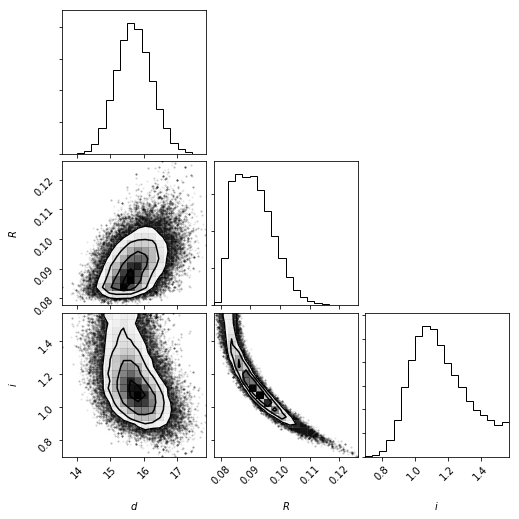

In [153]:
import corner 

samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$d$", "$R$", "$i$"],)
                     # truths=[m_true, b_true, np.log(f_true)])

In [ ]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)

multi_samples = reader.get_chain()

#map phi_a_distr to t0_distr:
multi_samples[:, :, 0] = np.interp(multi_samples[:,:,0],lc.phi,lc.t)

# map phi0 to phi_peak longitude, still call it phi0
multi_samples[:, :,-1] = multi_samples[:,:,0]%(2.*np.pi) - multi_samples[:,:, -1] # 0 would be facing the observer

# convert FWHM to days
multi_samples[:, :, 3] = multi_samples[:,:,3]/2/np.pi*target.Prot_d 

labels = [r'$t_\mathrm{f} [d]$', r'$\theta_\mathrm{f}$ [rad]', 
          'a', 'FWHM [d]', r'$i$ [rad]',
          r"$\phi_\mathrm{f}$ [rad]"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(multi_samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(multi_samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)
